In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import grad

# Load data

In [2]:
##### LOAD #########
# choose load file name
data_path = "/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/23lang_wav2_vec_features/"
languages = ["Assamese", "Bengali", "Bodo", "Dogri", "English", "Gujarati", "Hindi", "Kannada",
             "Kashmiri", "Konkani", "Maithili", "Malayalam", "Manipuri", "Marathi", "Nepali",
             "Odia", "Punjabi", "Sanskrit", "Santali", "Sindhi", "Tamil", "Telugu", "Urdu"]

# Function to load and label data
def load_and_label_data(language, is_hindi):
    X_train = np.load(data_path + f"X_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_train = np.load(data_path + f"y_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    X_valid = np.load(data_path + f"X_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_valid = np.load(data_path + f"y_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_train_binary = np.ones_like(y_train) if is_hindi else np.zeros_like(y_train)
    y_valid_binary = np.ones_like(y_valid) if is_hindi else np.zeros_like(y_valid)
    return X_train, y_train_binary, X_valid, y_valid_binary

# Load Hindi data
X_train_hindi, y_train_hindi, X_valid_hindi, y_valid_hindi = load_and_label_data("Hindi", True)

# Initialize lists for non-Hindi data
X_train_non_hindi_list = []
y_train_non_hindi_list = []
X_valid_non_hindi_list = []
y_valid_non_hindi_list = []

# Load non-Hindi data
for language in languages:
    if language != "Hindi":
        X_train_lang, y_train_lang, X_valid_lang, y_valid_lang = load_and_label_data(language, False)
        X_train_non_hindi_list.append(X_train_lang)
        y_train_non_hindi_list.append(y_train_lang)
        X_valid_non_hindi_list.append(X_valid_lang)
        y_valid_non_hindi_list.append(y_valid_lang)

# Concatenate non-Hindi data
X_train_non_hindi = np.vstack(X_train_non_hindi_list)
y_train_non_hindi = np.concatenate(y_train_non_hindi_list)
X_valid_non_hindi = np.vstack(X_valid_non_hindi_list)
y_valid_non_hindi = np.concatenate(y_valid_non_hindi_list)

# Balance non-Hindi samples
def balance_data(X, y, factor):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    indices = indices[:len(X) // factor]
    return X[indices], y[indices]

X_train_non_hindi_balanced, y_train_non_hindi_balanced = balance_data(X_train_non_hindi, y_train_non_hindi, 22)
X_valid_non_hindi_balanced, y_valid_non_hindi_balanced = balance_data(X_valid_non_hindi, y_valid_non_hindi, 22)
# Combine Hindi and non-Hindi data
X_train_combined = np.vstack((X_train_hindi, X_train_non_hindi_balanced))
y_train_combined = np.concatenate((y_train_hindi, y_train_non_hindi_balanced))
X_valid_combined = np.vstack((X_valid_hindi, X_valid_non_hindi_balanced))
y_valid_combined = np.concatenate((y_valid_hindi, y_valid_non_hindi_balanced))

# Check that we've recovered the right data
print(f'X_train: {X_train_combined.shape}, y_train: {y_train_combined.shape}')
print(f'X_valid: {X_valid_combined.shape}, y_valid: {y_valid_combined.shape}')


X_train: (1316, 300, 1024), y_train: (1316,)
X_valid: (346, 300, 1024), y_valid: (346,)


In [3]:
print(np.unique(y_train_combined,return_counts=True))
#print(np.unique(y_aug,return_counts=True))
print(np.unique(y_valid_combined,return_counts=True))

(array([0, 1], dtype=int16), array([1105,  211]))
(array([0, 1], dtype=int16), array([308,  38]))


In [ ]:
# #not doing where separate source domains are needed as X_aug such as wgdrl
# X_train=np.concatenate((X_train,X_aug))
# del X_aug
# y_train=np.concatenate((y_train,y_aug))
# del y_aug

# ECAPA TDNN

In [4]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channels, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector

    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

/home/bhagya/miniconda3/envs/env1/lib/python3.11/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


# Training

In [5]:
def xv_data_manage(X):
    X_transposed = X.transpose((0, 2, 1))
    print(X.shape, '-->', X_transposed.shape)
    return X_transposed


In [6]:
X_train_combined = xv_data_manage(X_train_combined)
X_valid_combined = xv_data_manage(X_valid_combined)

X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_combined, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_combined, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_combined, dtype=torch.long)




(1316, 300, 1024) --> (1316, 1024, 300)
(346, 300, 1024) --> (346, 1024, 300)


In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ECAPA_TDNN(1024, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)

In [11]:
trainloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=256, drop_last=False)
testloader1 = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True, batch_size=64, drop_last=False)
print(len(trainloader))
print(len(testloader1))

6
6


## Training cell

Epoch: 0, Batch: 0, Loss: 5.8866658210754395, Accuracy: 53.90625%
Total training loss 3.7932571371396384 and training Accuracy 70.82066869300911% after 0 epochs
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 3.1585192680358887, Accuracy:10.9375%


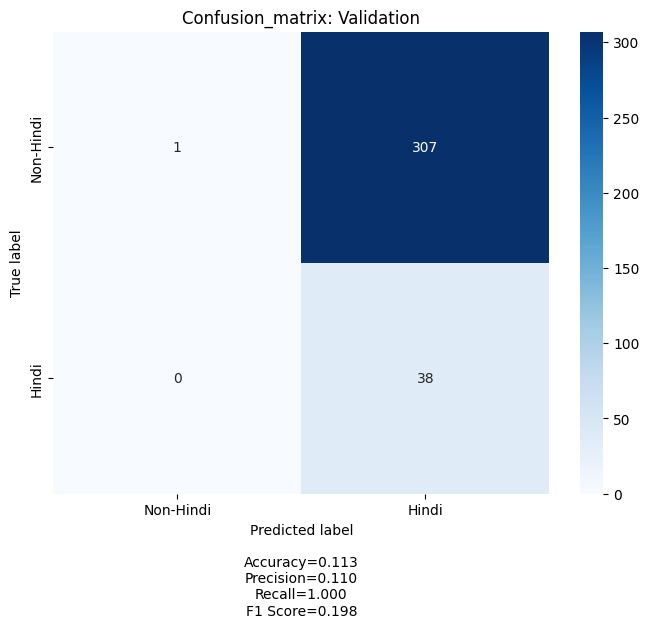

:::::Total validation loss 3.0502243041992188, Training accuracy 70.82066869300911%, Validation accuracy 11.271676300578035% after 0 epochs
Epoch: 1, Batch: 0, Loss: 1.6848578453063965, Accuracy: 91.796875%
Total training loss 1.3318656484285991 and training Accuracy 92.78115501519757% after 1 epochs
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 3.6512155532836914, Accuracy:20.3125%


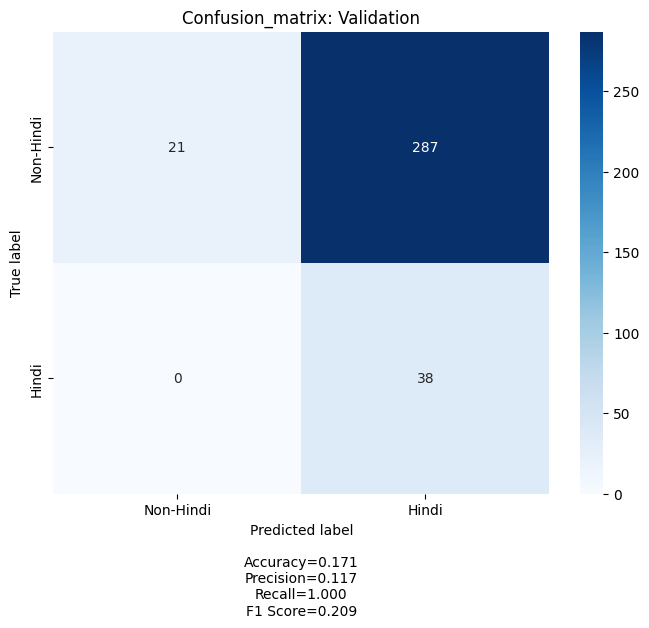

:::::Total validation loss 4.239192922910054, Training accuracy 92.78115501519757%, Validation accuracy 17.052023121387283% after 1 epochs
Epoch: 2, Batch: 0, Loss: 0.7613217234611511, Accuracy: 94.53125%
Total training loss 0.6990049829085668 and training Accuracy 96.42857142857143% after 2 epochs
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 2.9663779735565186, Accuracy:46.875%


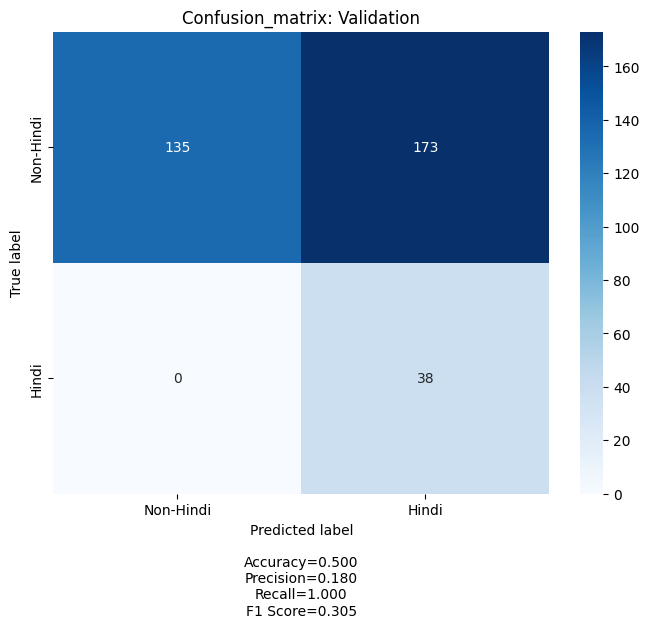

:::::Total validation loss 2.9387717644373574, Training accuracy 96.42857142857143%, Validation accuracy 50.0% after 2 epochs
Epoch: 3, Batch: 0, Loss: 0.1967795342206955, Accuracy: 98.828125%
Total training loss 0.19978143647313118 and training Accuracy 98.78419452887537% after 3 epochs
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 5.423680782318115, Accuracy:56.25%


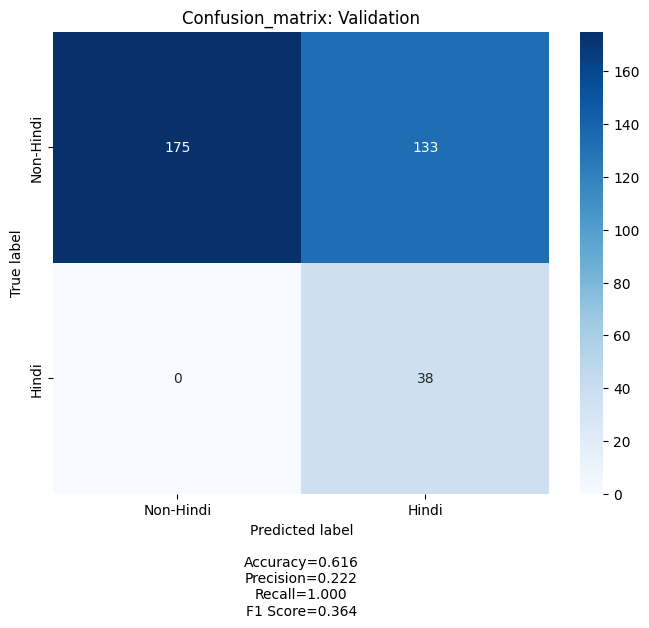

:::::Total validation loss 4.8881494998931885, Training accuracy 98.78419452887537%, Validation accuracy 61.5606936416185% after 3 epochs
Epoch: 4, Batch: 0, Loss: 0.07933206111192703, Accuracy: 99.609375%
Total training loss 0.711409472549955 and training Accuracy 99.08814589665653% after 4 epochs
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 3.470211982727051, Accuracy:78.125%


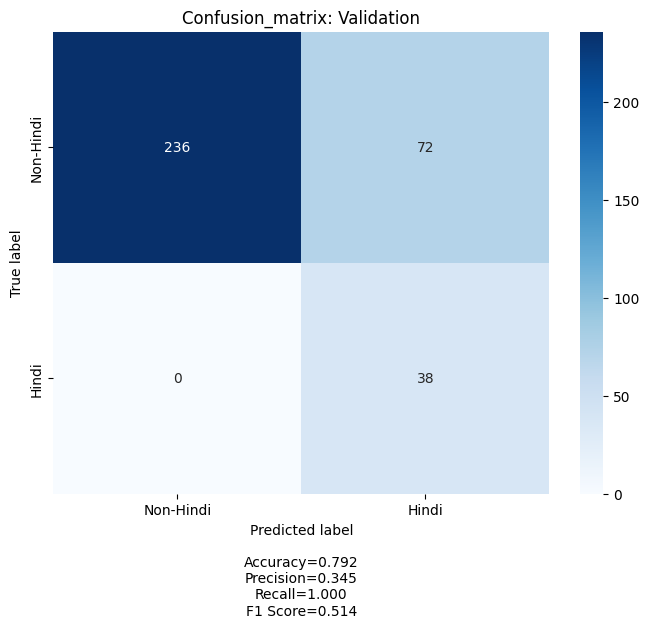

:::::Total validation loss 3.521656314531962, Training accuracy 99.08814589665653%, Validation accuracy 79.1907514450867% after 4 epochs
Epoch: 5, Batch: 0, Loss: 0.04251626878976822, Accuracy: 100.0%
Total training loss 0.2678833932926257 and training Accuracy 99.3920972644377% after 5 epochs
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 1.190004587173462, Accuracy:92.1875%


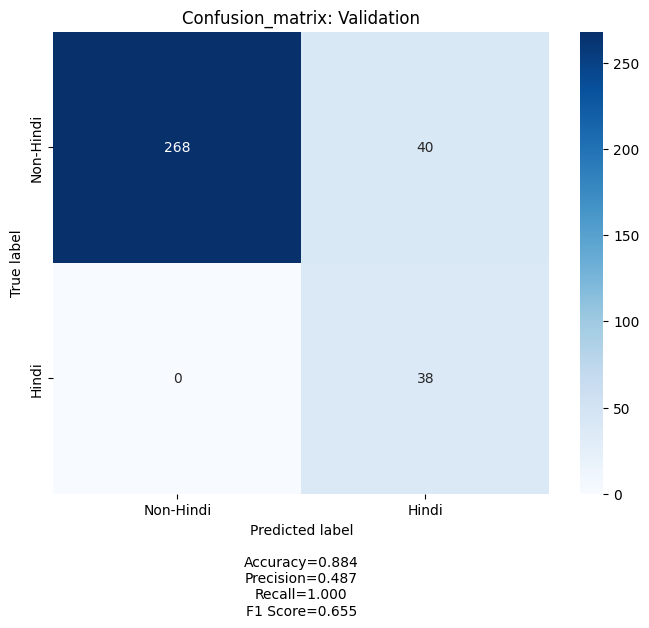

:::::Total validation loss 2.1392418444156647, Training accuracy 99.3920972644377%, Validation accuracy 88.4393063583815% after 5 epochs
Epoch: 6, Batch: 0, Loss: 0.20574906468391418, Accuracy: 98.828125%
Total training loss 0.1751248372408251 and training Accuracy 98.78419452887537% after 6 epochs
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 7.006602764129639, Accuracy:64.0625%


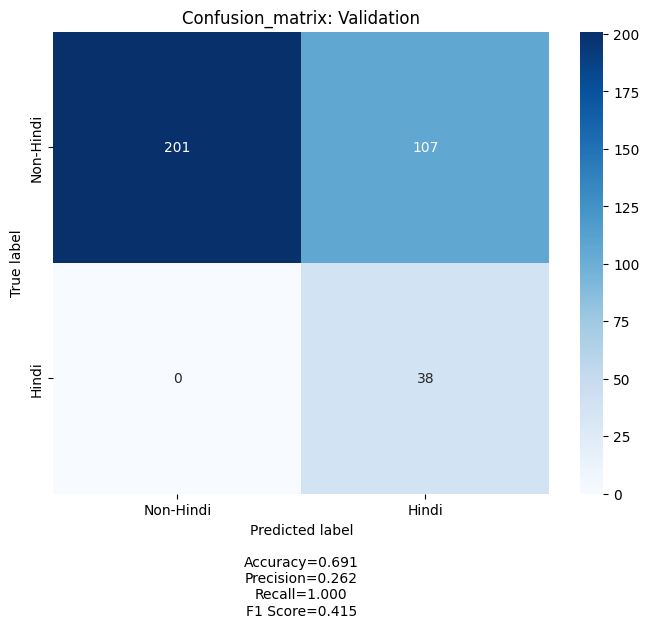

:::::Total validation loss 5.938361485799153, Training accuracy 98.78419452887537%, Validation accuracy 69.07514450867052% after 6 epochs
Epoch: 7, Batch: 0, Loss: 0.19418887794017792, Accuracy: 98.828125%
Total training loss 0.16210433406134447 and training Accuracy 98.93617021276596% after 7 epochs
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 2.5675573348999023, Accuracy:84.375%


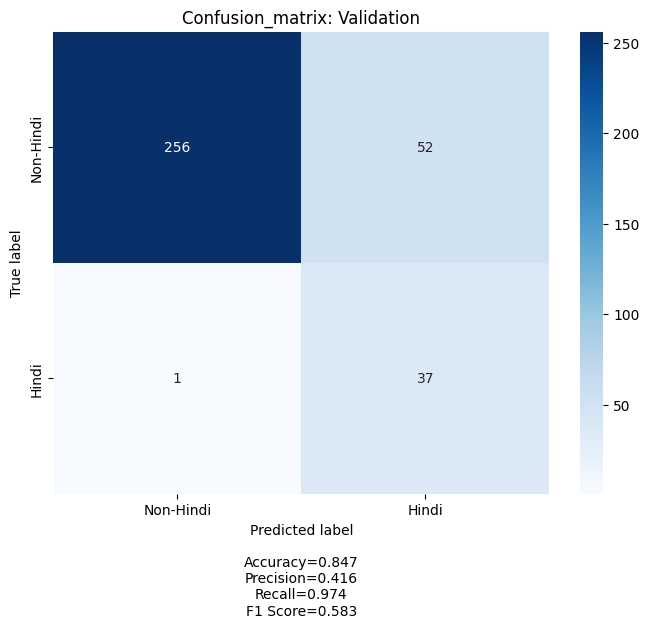

:::::Total validation loss 2.4903693795204163, Training accuracy 98.93617021276596%, Validation accuracy 84.6820809248555% after 7 epochs
Epoch: 8, Batch: 0, Loss: 0.05505634844303131, Accuracy: 99.609375%
Total training loss 0.09262128422657649 and training Accuracy 99.54407294832826% after 8 epochs
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 0.8195635080337524, Accuracy:93.75%


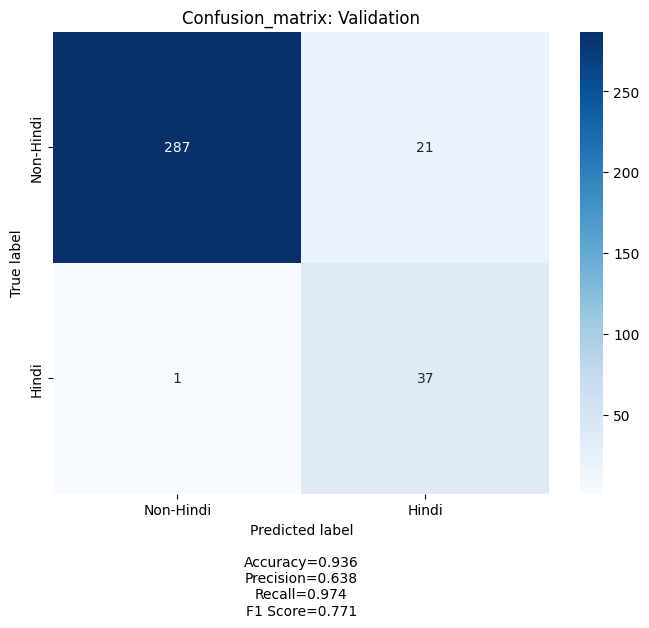

:::::Total validation loss 1.0514683400591214, Training accuracy 99.54407294832826%, Validation accuracy 93.64161849710982% after 8 epochs
Epoch: 9, Batch: 0, Loss: 0.10664026439189911, Accuracy: 99.21875%
Total training loss 0.06065925268922001 and training Accuracy 99.69604863221885% after 9 epochs
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 0.9010064005851746, Accuracy:92.1875%


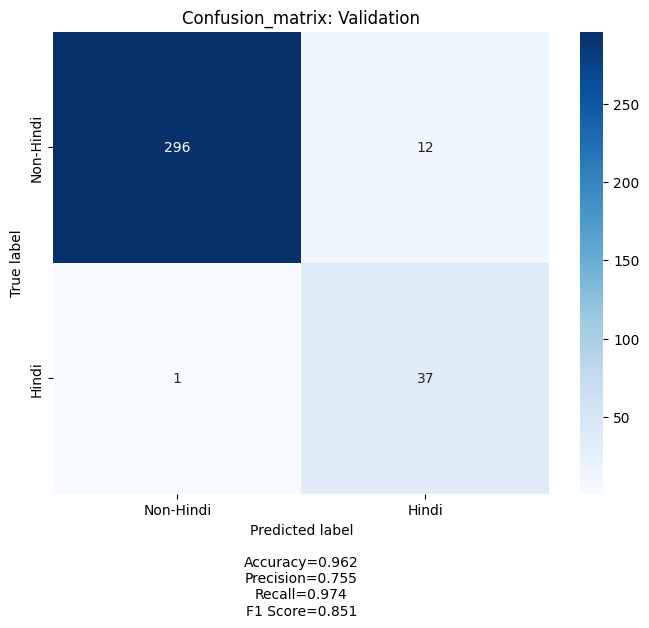

:::::Total validation loss 0.5054395531187765, Training accuracy 99.69604863221885%, Validation accuracy 96.24277456647398% after 9 epochs
Epoch: 10, Batch: 0, Loss: 0.011064800433814526, Accuracy: 100.0%
Total training loss 0.0824682346234719 and training Accuracy 99.84802431610942% after 10 epochs
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 0.7540686130523682, Accuracy:93.75%


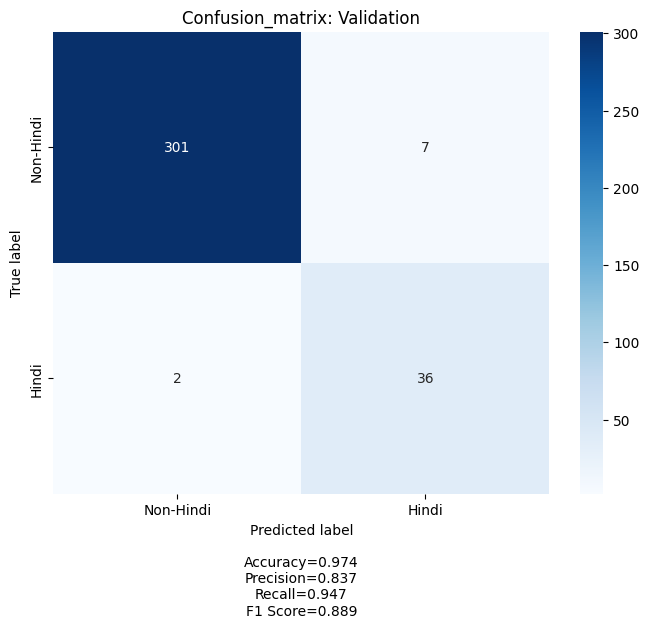

:::::Total validation loss 0.29223016327584145, Training accuracy 99.84802431610942%, Validation accuracy 97.39884393063583% after 10 epochs
Epoch: 11, Batch: 0, Loss: 0.006240245886147022, Accuracy: 100.0%
Total training loss 0.23360323215213916 and training Accuracy 99.77203647416414% after 11 epochs
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 0.9640865921974182, Accuracy:92.1875%


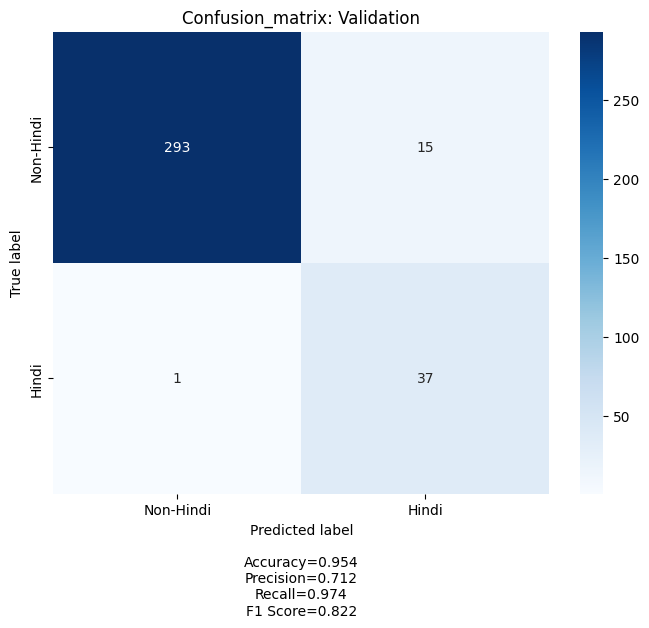

:::::Total validation loss 0.49194240880509216, Training accuracy 99.77203647416414%, Validation accuracy 95.37572254335261% after 11 epochs
Epoch: 12, Batch: 0, Loss: 0.0048159328289330006, Accuracy: 100.0%
Total training loss 0.016901034881205607 and training Accuracy 99.92401215805471% after 12 epochs
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 0.7550911903381348, Accuracy:95.3125%


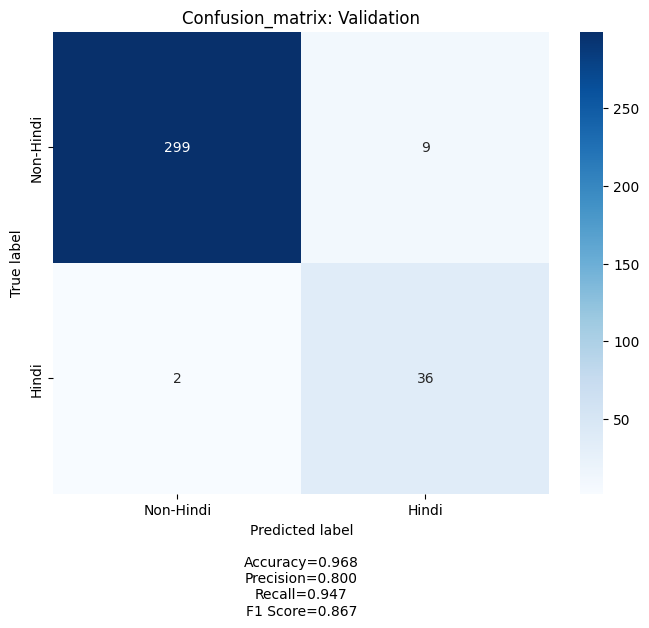

:::::Total validation loss 0.32447123364545405, Training accuracy 99.92401215805471%, Validation accuracy 96.82080924855492% after 12 epochs
Epoch: 13, Batch: 0, Loss: 0.018290847539901733, Accuracy: 100.0%
Total training loss 0.18658593902364373 and training Accuracy 99.77203647416414% after 13 epochs
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 0.4788285791873932, Accuracy:96.875%


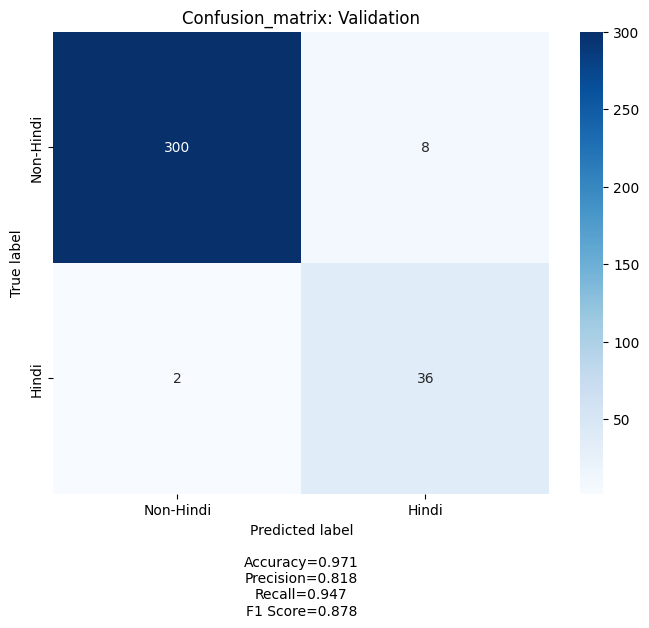

:::::Total validation loss 0.3317716013795386, Training accuracy 99.77203647416414%, Validation accuracy 97.10982658959537% after 13 epochs
Epoch: 14, Batch: 0, Loss: 0.0063166567124426365, Accuracy: 100.0%
Total training loss 0.023719123642270763 and training Accuracy 100.0% after 14 epochs
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 0.6907764673233032, Accuracy:92.1875%


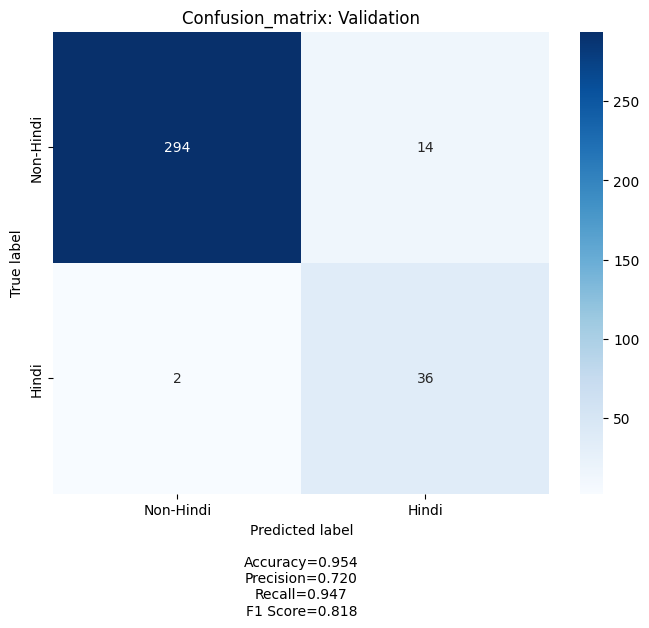

:::::Total validation loss 0.6325622896353403, Training accuracy 100.0%, Validation accuracy 95.37572254335261% after 14 epochs
Epoch: 15, Batch: 0, Loss: 0.07455845922231674, Accuracy: 99.609375%
Total training loss 0.04369333335004436 and training Accuracy 99.77203647416414% after 15 epochs
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 0.28867867588996887, Accuracy:98.4375%


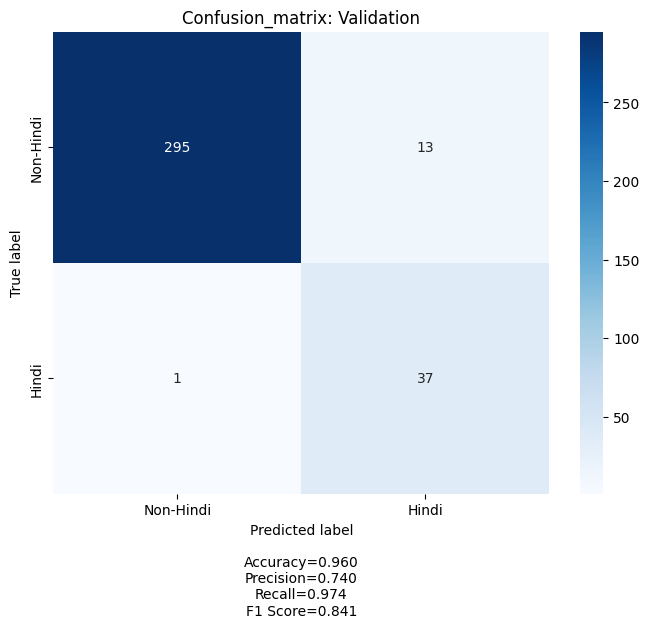

:::::Total validation loss 0.5730632929465699, Training accuracy 99.77203647416414%, Validation accuracy 95.95375722543352% after 15 epochs
Epoch: 16, Batch: 0, Loss: 0.061810288578271866, Accuracy: 99.609375%
Total training loss 0.021923828598422308 and training Accuracy 99.92401215805471% after 16 epochs
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 1.618969440460205, Accuracy:90.625%


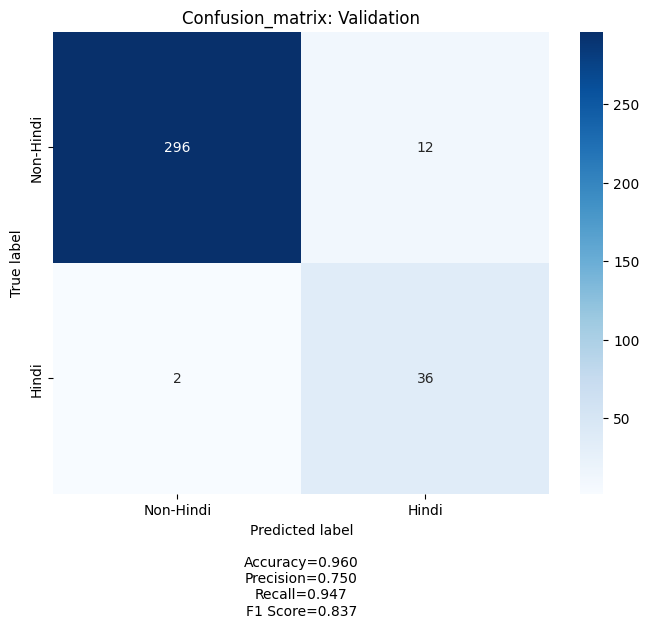

:::::Total validation loss 0.4900364186762876, Training accuracy 99.92401215805471%, Validation accuracy 95.95375722543352% after 16 epochs
Epoch: 17, Batch: 0, Loss: 0.002453718800097704, Accuracy: 100.0%
Total training loss 0.011105296784080565 and training Accuracy 100.0% after 17 epochs
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 0.41495558619499207, Accuracy:96.875%


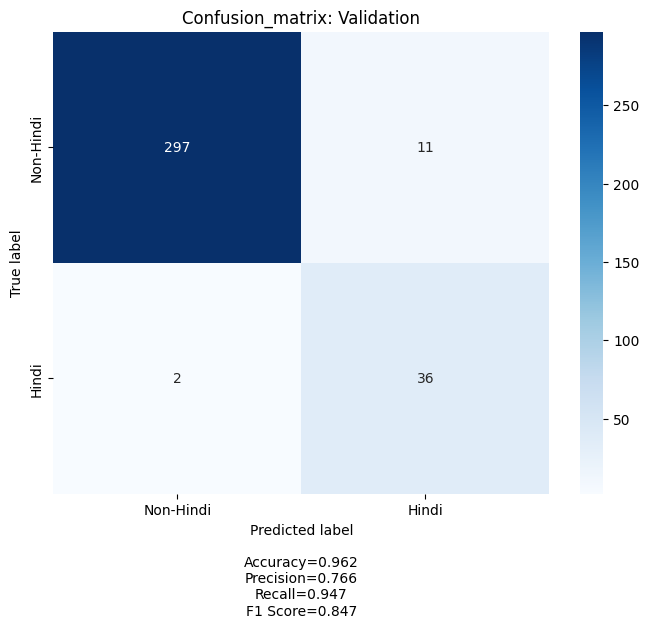

:::::Total validation loss 0.4648803696036339, Training accuracy 100.0%, Validation accuracy 96.24277456647398% after 17 epochs
Epoch: 18, Batch: 0, Loss: 0.0022636253852397203, Accuracy: 100.0%
Total training loss 0.08399295021081343 and training Accuracy 99.84802431610942% after 18 epochs
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 0.0189764853566885, Accuracy:98.4375%


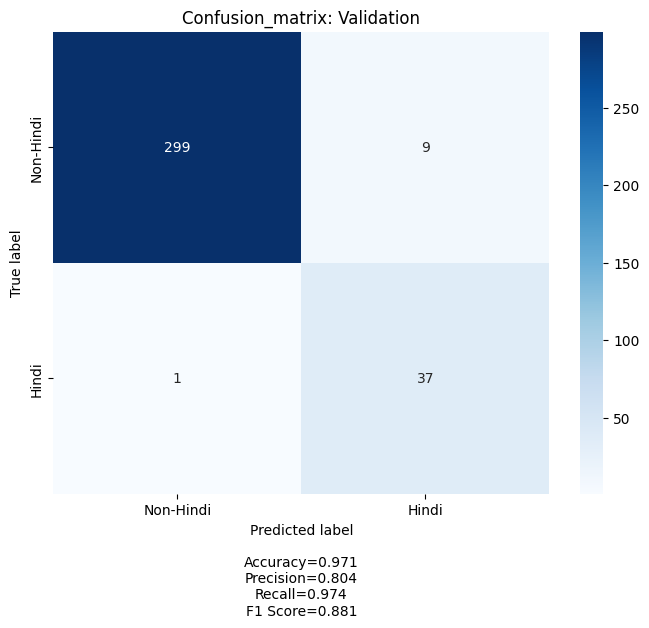

:::::Total validation loss 0.395753573315839, Training accuracy 99.84802431610942%, Validation accuracy 97.10982658959537% after 18 epochs
Epoch: 19, Batch: 0, Loss: 0.005179756786674261, Accuracy: 100.0%
Total training loss 0.08603801069936405 and training Accuracy 99.84802431610942% after 19 epochs
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 0.17319874465465546, Accuracy:98.4375%


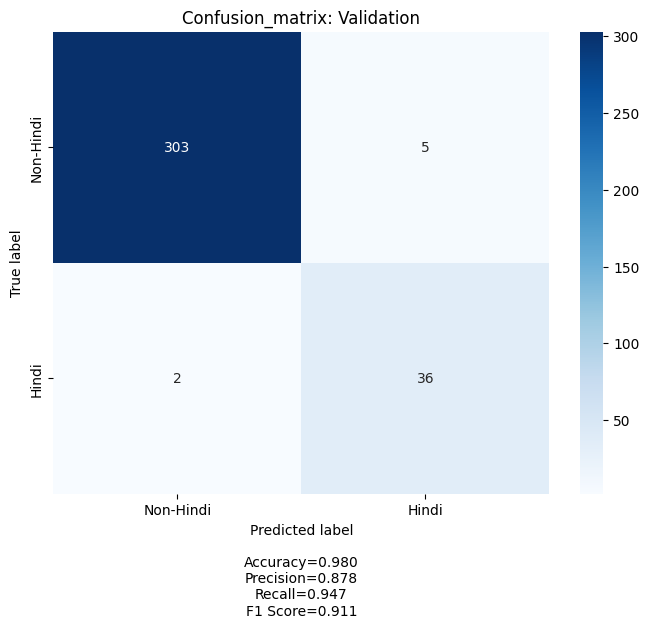

:::::Total validation loss 0.24585344336690204, Training accuracy 99.84802431610942%, Validation accuracy 97.97687861271676% after 19 epochs
Epoch: 20, Batch: 0, Loss: 0.015565494075417519, Accuracy: 100.0%
Total training loss 0.00548322402270666 and training Accuracy 100.0% after 20 epochs
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 0.11133823543787003, Accuracy:98.4375%


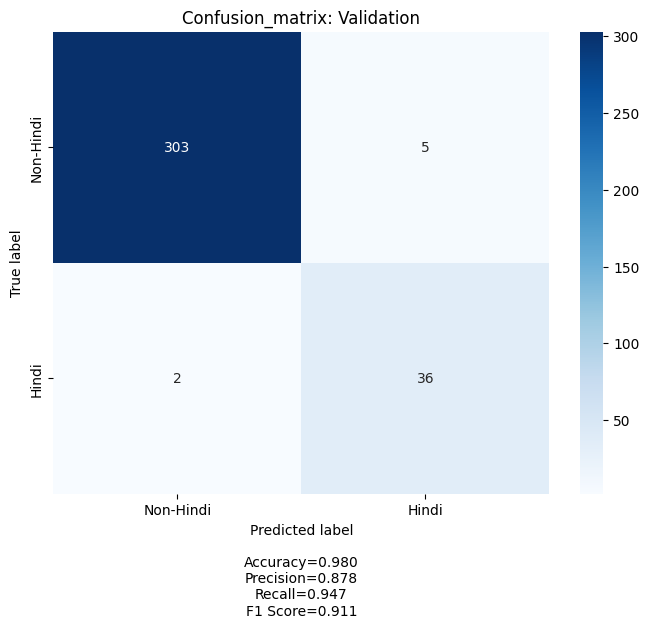

:::::Total validation loss 0.26327584648970515, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 20 epochs
Epoch: 21, Batch: 0, Loss: 0.0017071395413950086, Accuracy: 100.0%
Total training loss 0.005723602031745638 and training Accuracy 100.0% after 21 epochs
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 0.22947004437446594, Accuracy:98.4375%


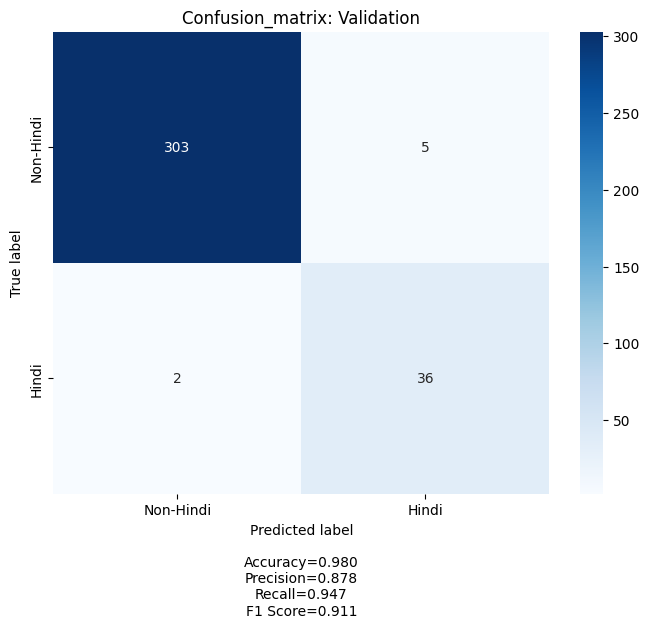

:::::Total validation loss 0.3323743409224941, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 21 epochs
Epoch: 22, Batch: 0, Loss: 0.003343814518302679, Accuracy: 100.0%
Total training loss 0.007556567628247042 and training Accuracy 100.0% after 22 epochs
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 0.31991276144981384, Accuracy:98.4375%


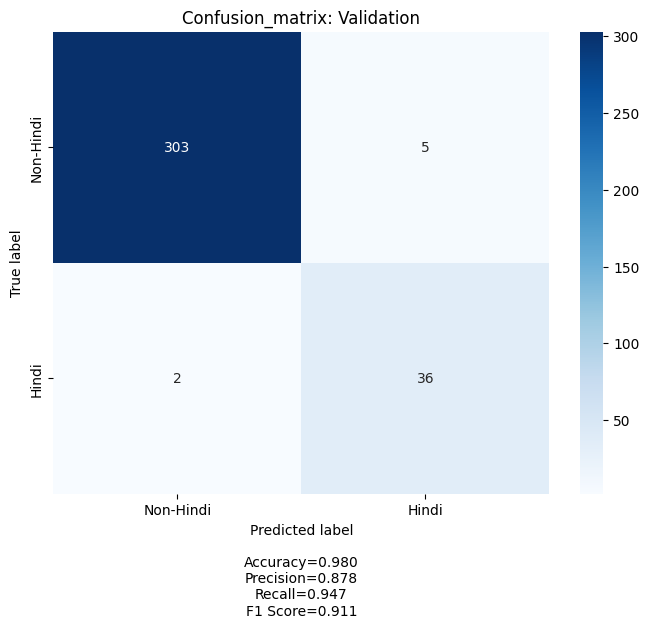

:::::Total validation loss 0.29997367846469086, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 22 epochs
Epoch: 23, Batch: 0, Loss: 0.0015913674142211676, Accuracy: 100.0%
Total training loss 0.0018314307477946083 and training Accuracy 100.0% after 23 epochs
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 0.29082629084587097, Accuracy:98.4375%


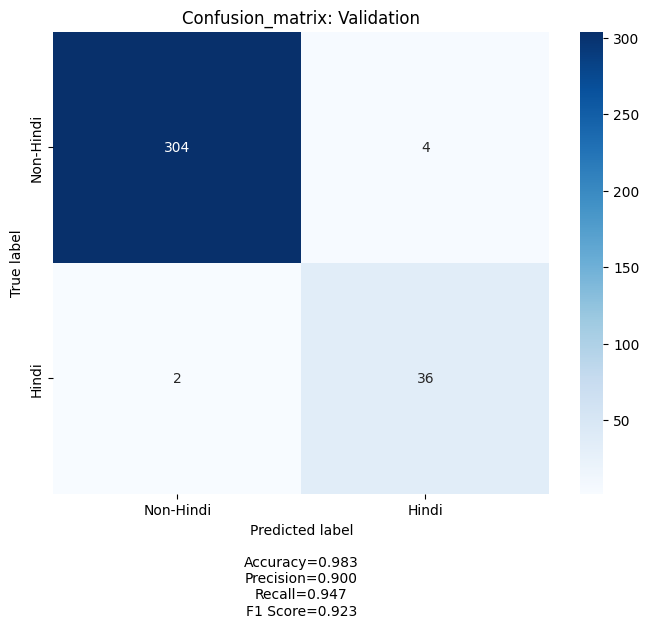

:::::Total validation loss 0.32477217090005556, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 23 epochs
Epoch: 24, Batch: 0, Loss: 0.003472409676760435, Accuracy: 100.0%
Total training loss 0.020205959857169848 and training Accuracy 100.0% after 24 epochs
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 0.7305374145507812, Accuracy:93.75%


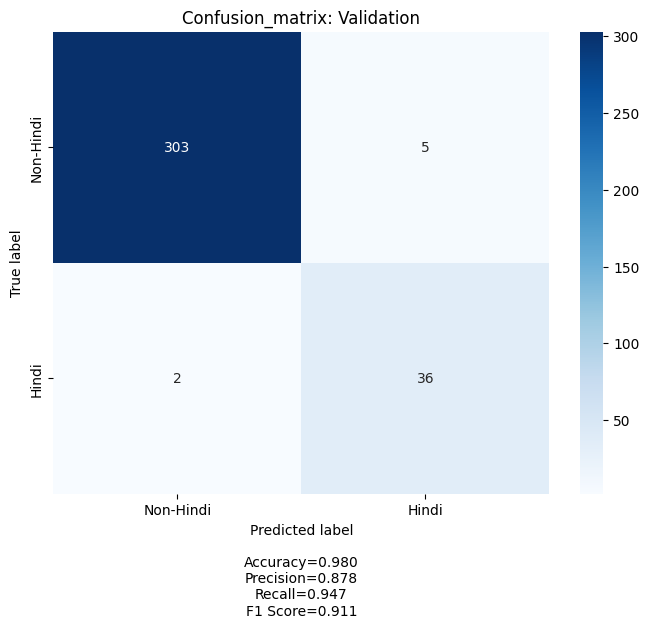

:::::Total validation loss 0.22801654134915714, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 24 epochs
Epoch: 25, Batch: 0, Loss: 0.0015422891592606902, Accuracy: 100.0%
Total training loss 0.08809039052963878 and training Accuracy 99.92401215805471% after 25 epochs
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 0.07071791589260101, Accuracy:96.875%


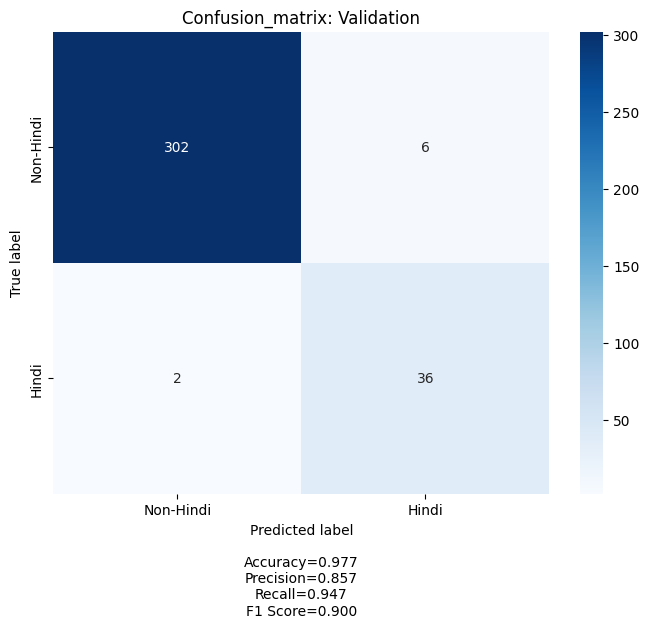

:::::Total validation loss 0.24409173864305936, Training accuracy 99.92401215805471%, Validation accuracy 97.6878612716763% after 25 epochs
Epoch: 26, Batch: 0, Loss: 0.00156975700519979, Accuracy: 100.0%
Total training loss 0.00567823153687641 and training Accuracy 100.0% after 26 epochs
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 0.6299984455108643, Accuracy:93.75%


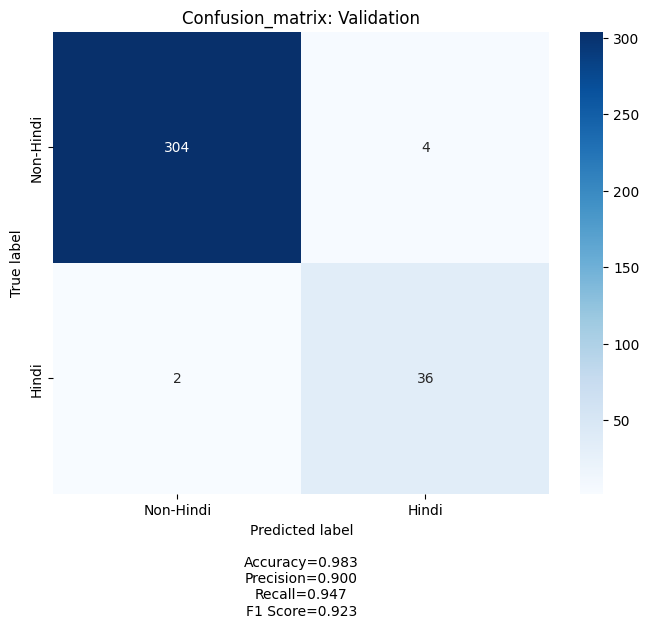

:::::Total validation loss 0.18074737815160624, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 26 epochs
Epoch: 27, Batch: 0, Loss: 0.009415144100785255, Accuracy: 100.0%
Total training loss 0.01740669715218246 and training Accuracy 99.84802431610942% after 27 epochs
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 0.5285934805870056, Accuracy:95.3125%


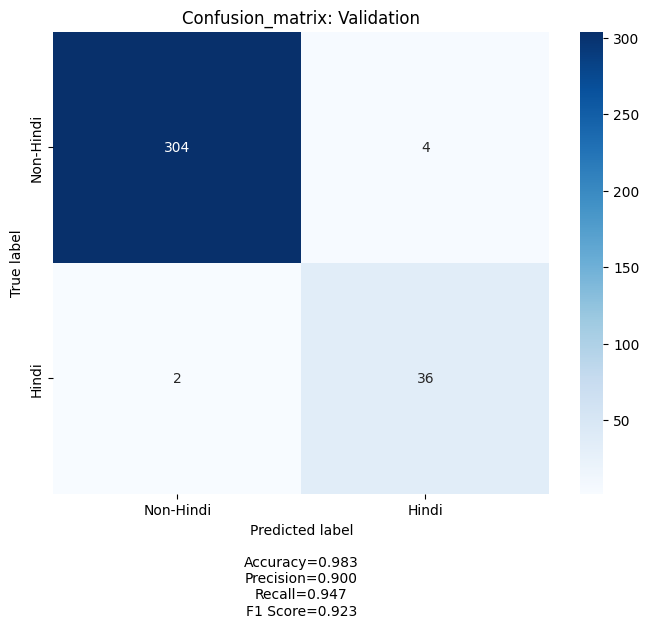

:::::Total validation loss 0.18967777959286045, Training accuracy 99.84802431610942%, Validation accuracy 98.26589595375722% after 27 epochs
Epoch: 28, Batch: 0, Loss: 0.00419372646138072, Accuracy: 100.0%
Total training loss 0.005756271956973554 and training Accuracy 100.0% after 28 epochs
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 0.5161943435668945, Accuracy:96.875%


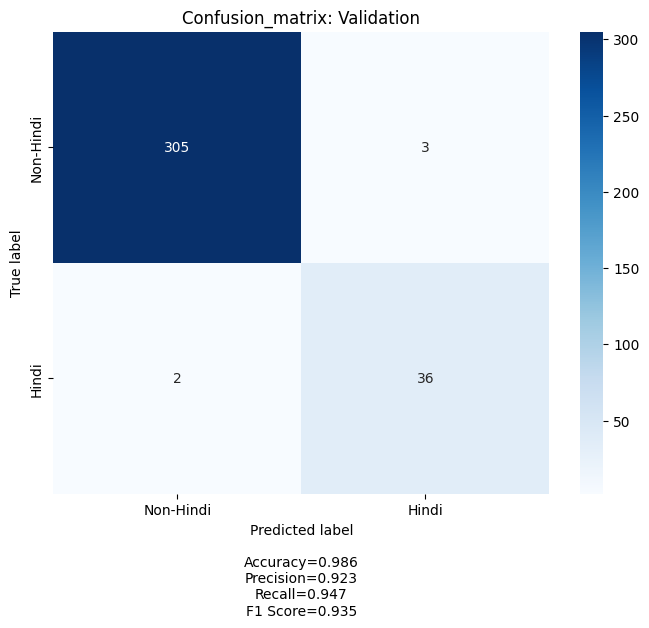

:::::Total validation loss 0.17407304004658583, Training accuracy 100.0%, Validation accuracy 98.55491329479769% after 28 epochs
Epoch: 29, Batch: 0, Loss: 0.003078772220760584, Accuracy: 100.0%
Total training loss 0.00791314160839344 and training Accuracy 100.0% after 29 epochs
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 1.2068812847137451, Accuracy:90.625%


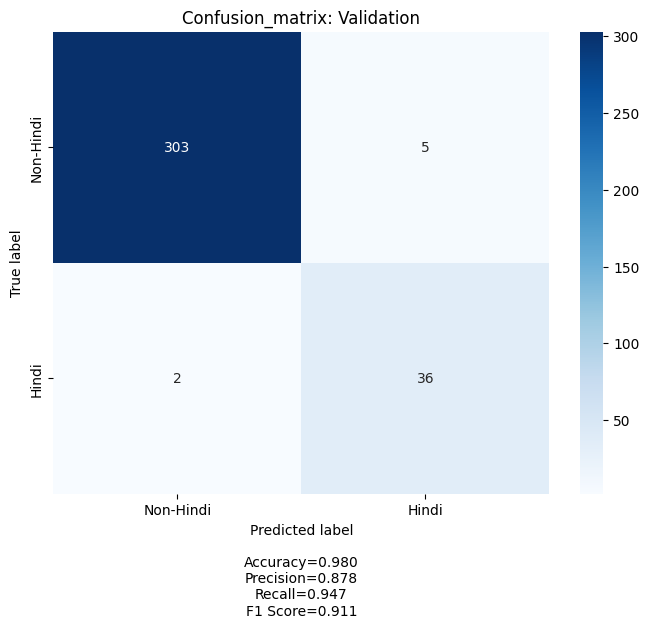

:::::Total validation loss 0.20483137194704515, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 29 epochs
Epoch: 30, Batch: 0, Loss: 0.0021136216819286346, Accuracy: 100.0%
Total training loss 0.004519090376561508 and training Accuracy 100.0% after 30 epochs
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 0.26200467348098755, Accuracy:98.4375%


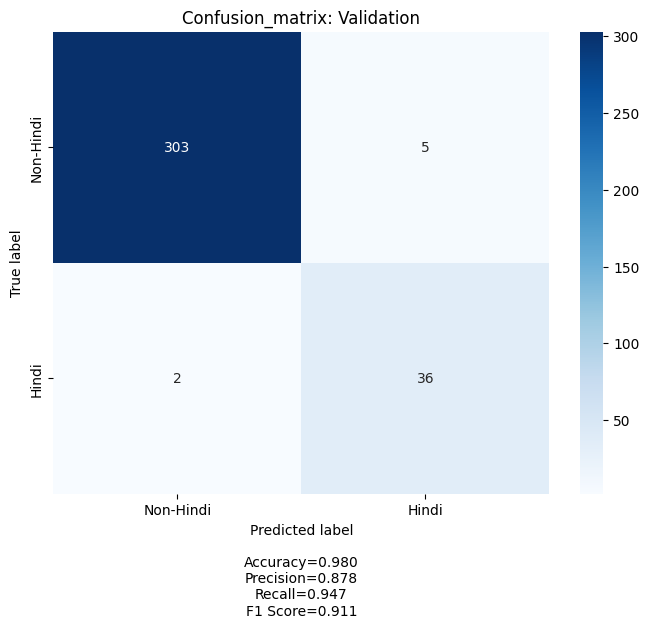

:::::Total validation loss 0.1990182023079683, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 30 epochs
Epoch: 31, Batch: 0, Loss: 0.003262261627241969, Accuracy: 100.0%
Total training loss 0.017232954657326143 and training Accuracy 100.0% after 31 epochs
#####TEST--in-domain:::::Epoch: 31, Batch: 0, Loss: 0.25927767157554626, Accuracy:98.4375%


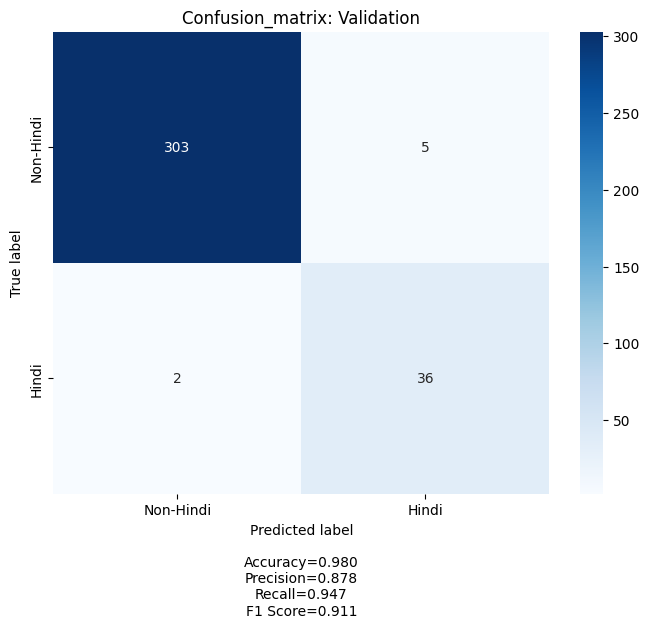

:::::Total validation loss 0.20939666032791138, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 31 epochs
Epoch: 32, Batch: 0, Loss: 0.0009354586363770068, Accuracy: 100.0%
Total training loss 0.0032800771781088165 and training Accuracy 100.0% after 32 epochs
#####TEST--in-domain:::::Epoch: 32, Batch: 0, Loss: 0.27999791502952576, Accuracy:96.875%


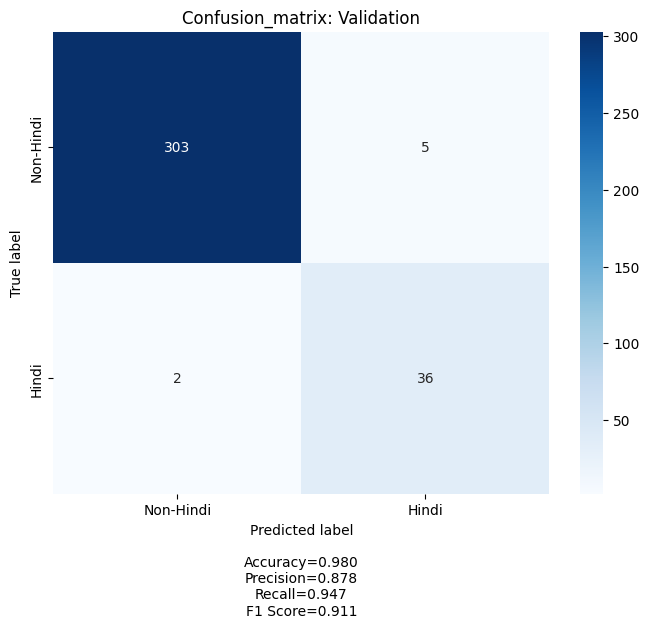

:::::Total validation loss 0.26743918626111923, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 32 epochs
Epoch: 33, Batch: 0, Loss: 0.002134631620720029, Accuracy: 100.0%
Total training loss 0.0029187448672018945 and training Accuracy 100.0% after 33 epochs
#####TEST--in-domain:::::Epoch: 33, Batch: 0, Loss: 0.11479154229164124, Accuracy:98.4375%


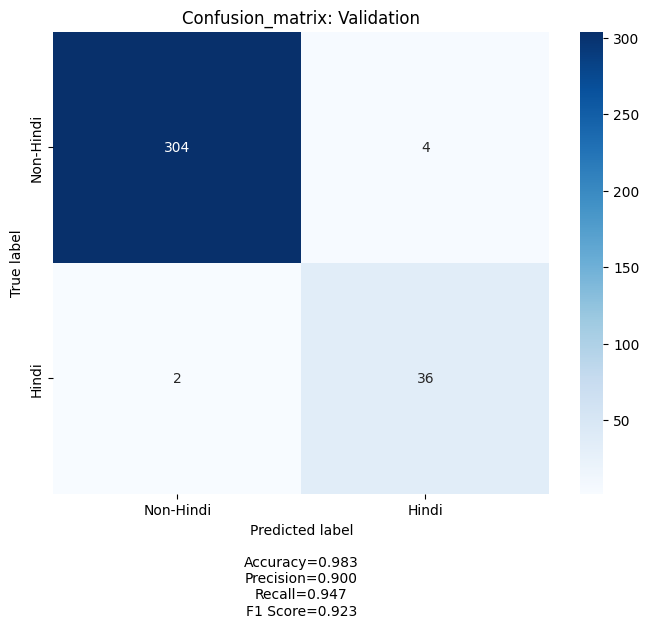

:::::Total validation loss 0.20926393164453572, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 33 epochs
Epoch: 34, Batch: 0, Loss: 0.0018981934990733862, Accuracy: 100.0%
Total training loss 0.008966240178172788 and training Accuracy 100.0% after 34 epochs
#####TEST--in-domain:::::Epoch: 34, Batch: 0, Loss: 0.26396405696868896, Accuracy:98.4375%


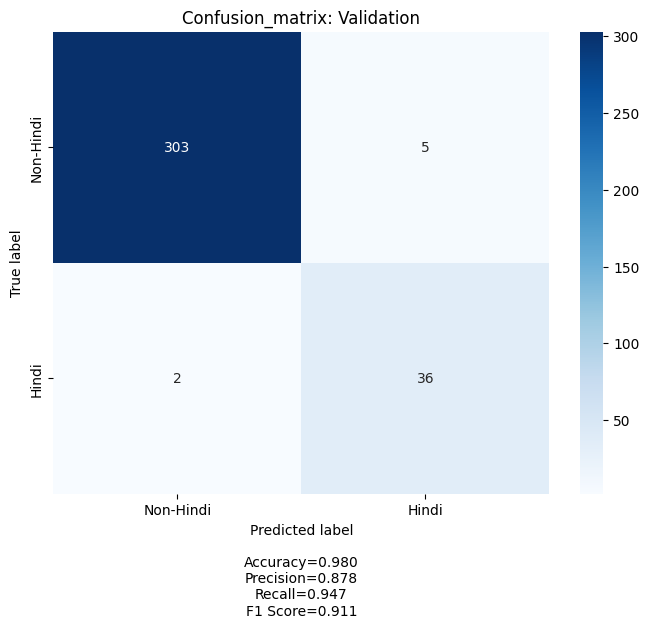

:::::Total validation loss 0.20367690268892127, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 34 epochs
Epoch: 35, Batch: 0, Loss: 0.0014784210361540318, Accuracy: 100.0%
Total training loss 0.0010807880995950352 and training Accuracy 100.0% after 35 epochs
#####TEST--in-domain:::::Epoch: 35, Batch: 0, Loss: 0.3941231667995453, Accuracy:95.3125%


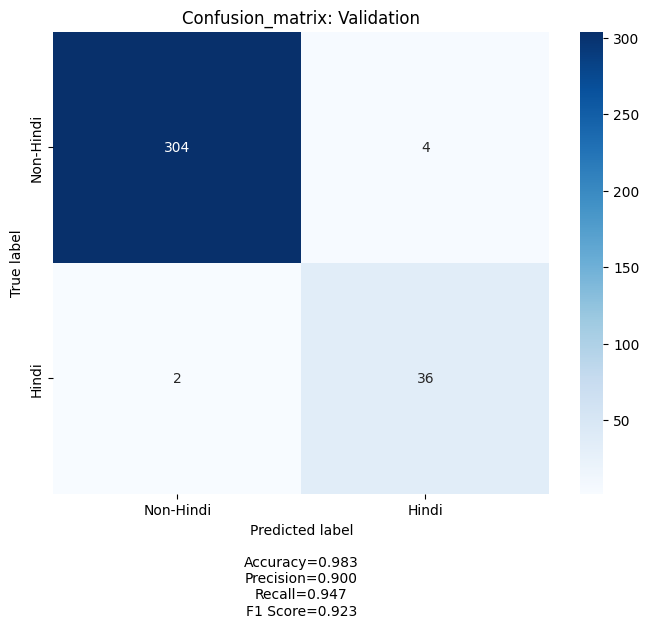

:::::Total validation loss 0.20118282511923744, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 35 epochs
Epoch: 36, Batch: 0, Loss: 0.01898687519133091, Accuracy: 100.0%
Total training loss 0.006832588551333174 and training Accuracy 100.0% after 36 epochs
#####TEST--in-domain:::::Epoch: 36, Batch: 0, Loss: 0.20882093906402588, Accuracy:98.4375%


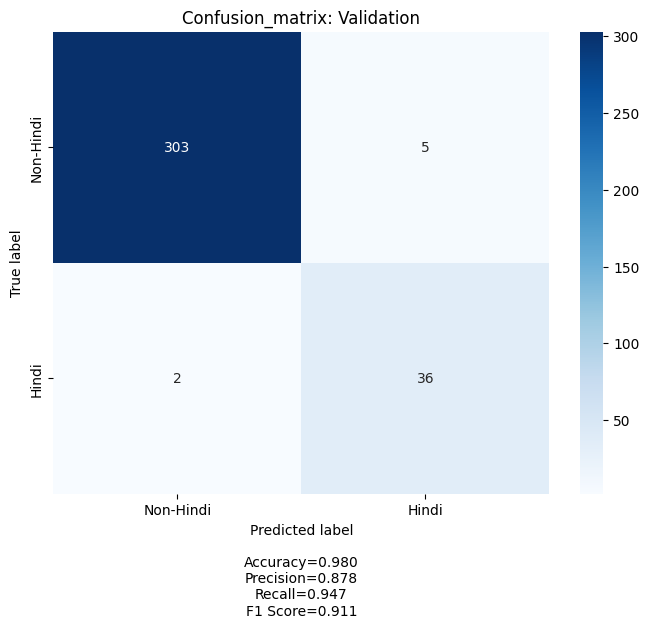

:::::Total validation loss 0.2535013596837719, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 36 epochs
Epoch: 37, Batch: 0, Loss: 0.006552509963512421, Accuracy: 100.0%
Total training loss 0.0036377226642798632 and training Accuracy 100.0% after 37 epochs
#####TEST--in-domain:::::Epoch: 37, Batch: 0, Loss: 0.0974966436624527, Accuracy:96.875%


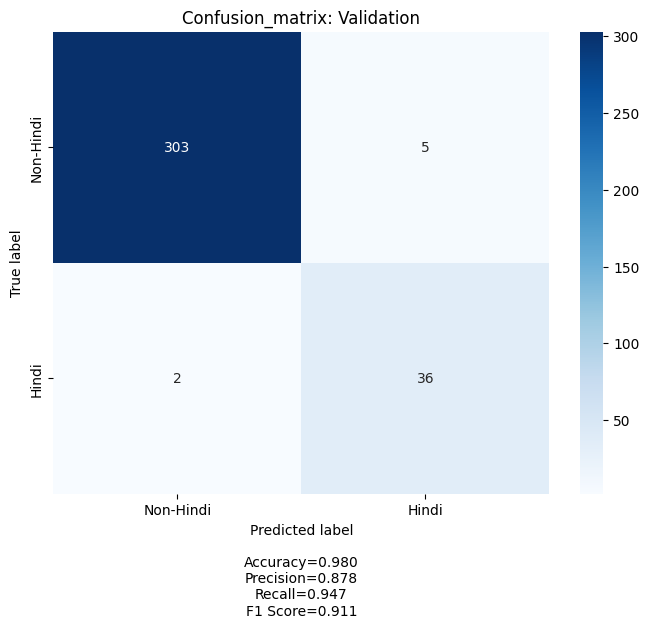

:::::Total validation loss 0.28255050998025233, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 37 epochs
Epoch: 38, Batch: 0, Loss: 0.0037083171773701906, Accuracy: 100.0%
Total training loss 0.0018662393740669359 and training Accuracy 100.0% after 38 epochs
#####TEST--in-domain:::::Epoch: 38, Batch: 0, Loss: 0.7916437387466431, Accuracy:95.3125%


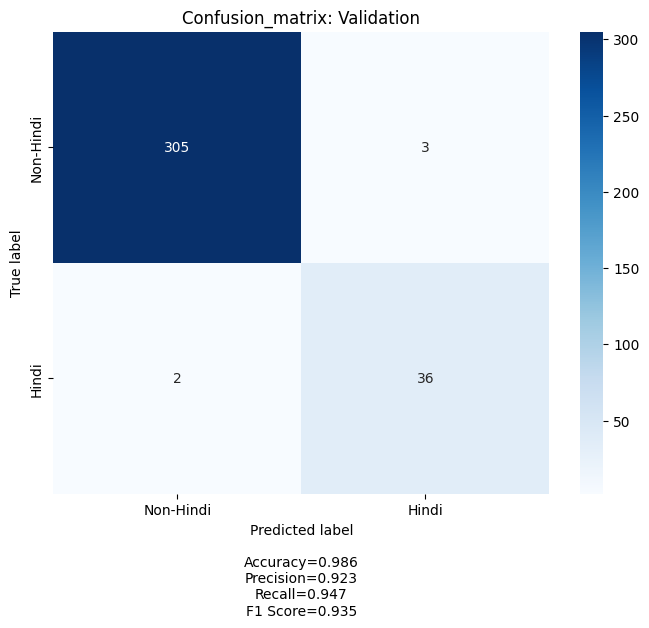

:::::Total validation loss 0.18752428842708335, Training accuracy 100.0%, Validation accuracy 98.55491329479769% after 38 epochs
Epoch: 39, Batch: 0, Loss: 0.0023758786264806986, Accuracy: 100.0%
Total training loss 0.002147042644840743 and training Accuracy 100.0% after 39 epochs
#####TEST--in-domain:::::Epoch: 39, Batch: 0, Loss: 0.1895103007555008, Accuracy:98.4375%


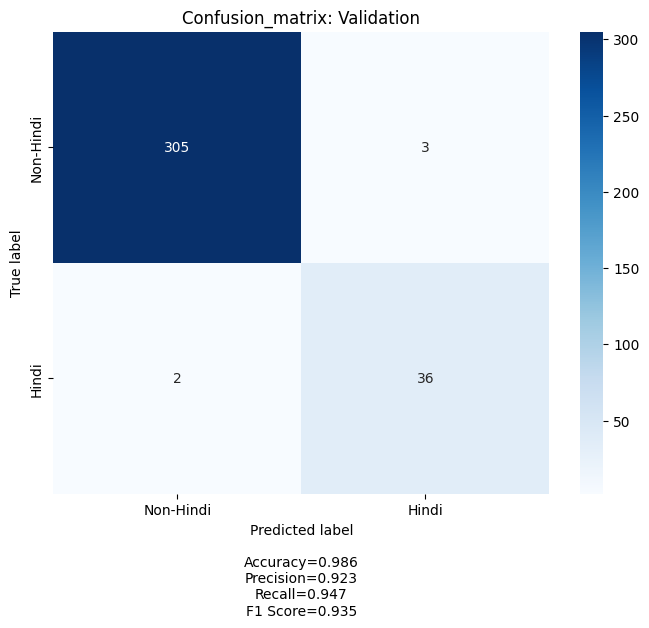

:::::Total validation loss 0.17322495556921544, Training accuracy 100.0%, Validation accuracy 98.55491329479769% after 39 epochs
Epoch: 40, Batch: 0, Loss: 0.0014581817667931318, Accuracy: 100.0%
Total training loss 0.1596864665237566 and training Accuracy 99.77203647416414% after 40 epochs
#####TEST--in-domain:::::Epoch: 40, Batch: 0, Loss: 0.4677508473396301, Accuracy:96.875%


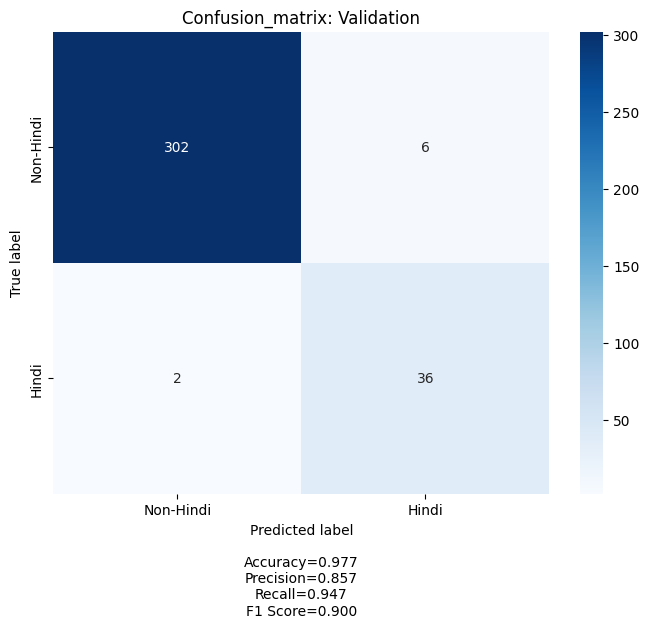

:::::Total validation loss 0.23799653141759336, Training accuracy 99.77203647416414%, Validation accuracy 97.6878612716763% after 40 epochs
Epoch: 41, Batch: 0, Loss: 0.0019238649401813745, Accuracy: 100.0%
Total training loss 0.0017441771293912705 and training Accuracy 100.0% after 41 epochs
#####TEST--in-domain:::::Epoch: 41, Batch: 0, Loss: 9.75050079432549e-06, Accuracy:100.0%


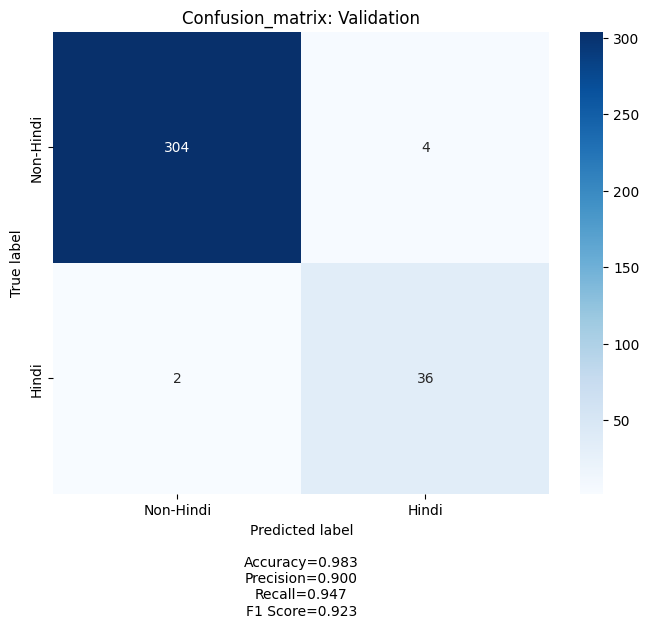

:::::Total validation loss 0.33695193253955197, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 41 epochs
Epoch: 42, Batch: 0, Loss: 0.003358101239427924, Accuracy: 100.0%
Total training loss 0.004419910294624667 and training Accuracy 100.0% after 42 epochs
#####TEST--in-domain:::::Epoch: 42, Batch: 0, Loss: 0.2661966383457184, Accuracy:98.4375%


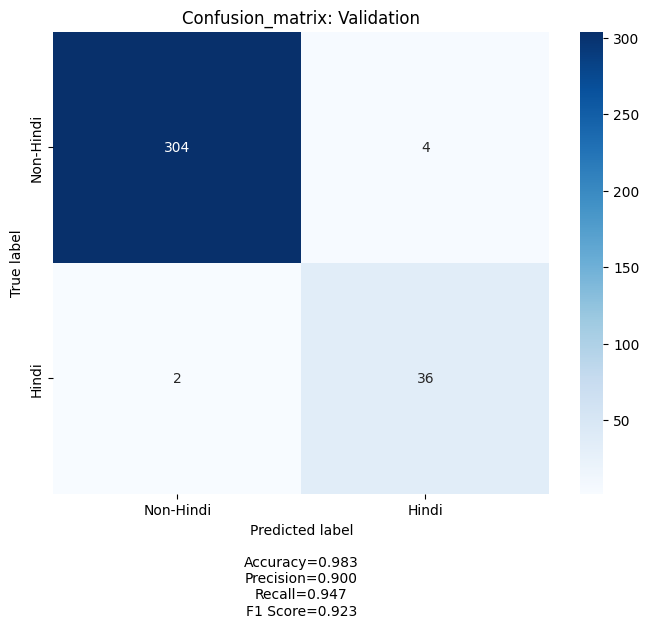

:::::Total validation loss 0.19820226088930357, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 42 epochs
Epoch: 43, Batch: 0, Loss: 0.0018572774715721607, Accuracy: 100.0%
Total training loss 0.0016284738327764596 and training Accuracy 100.0% after 43 epochs
#####TEST--in-domain:::::Epoch: 43, Batch: 0, Loss: 0.7293789982795715, Accuracy:95.3125%


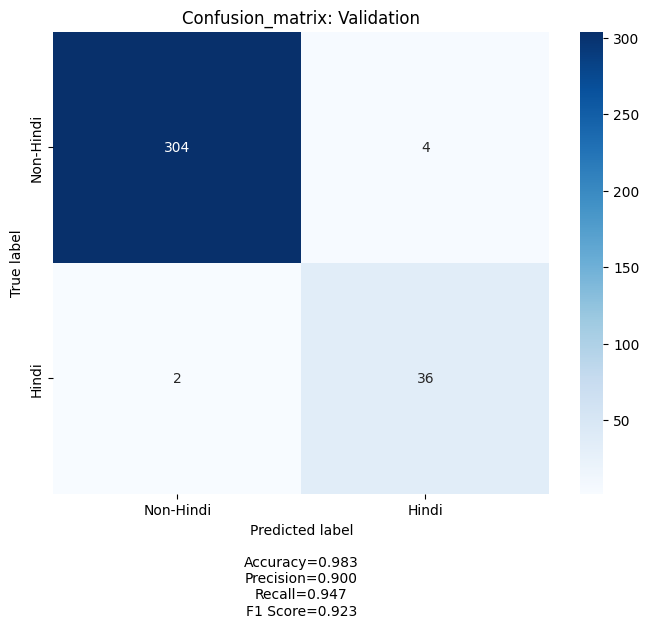

:::::Total validation loss 0.20140223763291232, Training accuracy 100.0%, Validation accuracy 98.26589595375722% after 43 epochs
Epoch: 44, Batch: 0, Loss: 0.002348025795072317, Accuracy: 100.0%
Total training loss 0.03292425063167078 and training Accuracy 99.92401215805471% after 44 epochs
#####TEST--in-domain:::::Epoch: 44, Batch: 0, Loss: 0.41742321848869324, Accuracy:96.875%


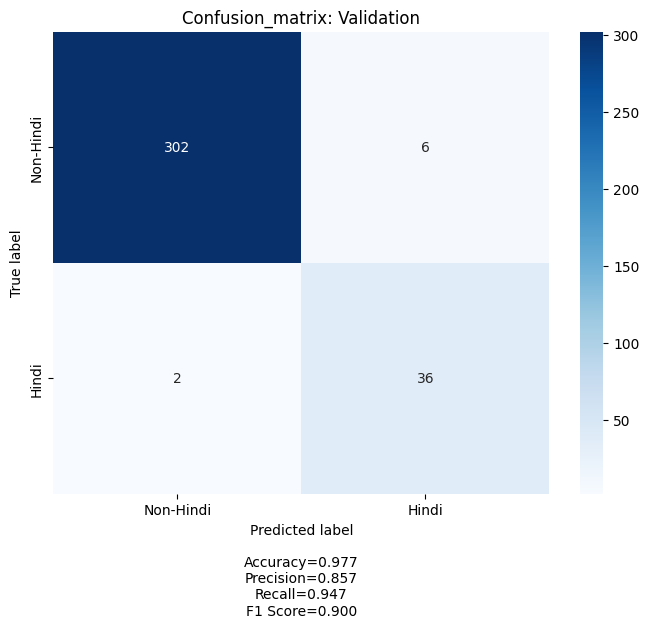

:::::Total validation loss 0.23355531816681227, Training accuracy 99.92401215805471%, Validation accuracy 97.6878612716763% after 44 epochs
Epoch: 45, Batch: 0, Loss: 0.001372046652249992, Accuracy: 100.0%
Total training loss 0.1996390497079119 and training Accuracy 99.84802431610942% after 45 epochs
#####TEST--in-domain:::::Epoch: 45, Batch: 0, Loss: 0.3385823965072632, Accuracy:95.3125%


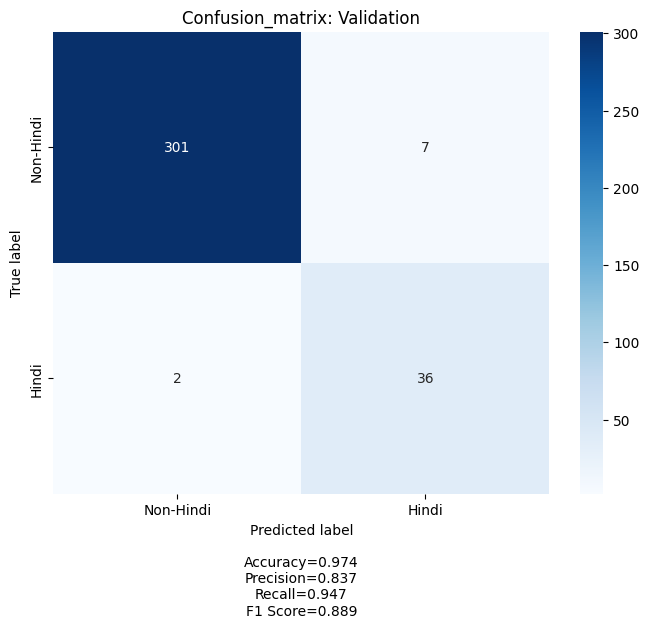

:::::Total validation loss 0.26909663367284037, Training accuracy 99.84802431610942%, Validation accuracy 97.39884393063583% after 45 epochs
Epoch: 46, Batch: 0, Loss: 0.0046904804185032845, Accuracy: 100.0%
Total training loss 0.006162190577015281 and training Accuracy 100.0% after 46 epochs
#####TEST--in-domain:::::Epoch: 46, Batch: 0, Loss: 0.2360217422246933, Accuracy:96.875%


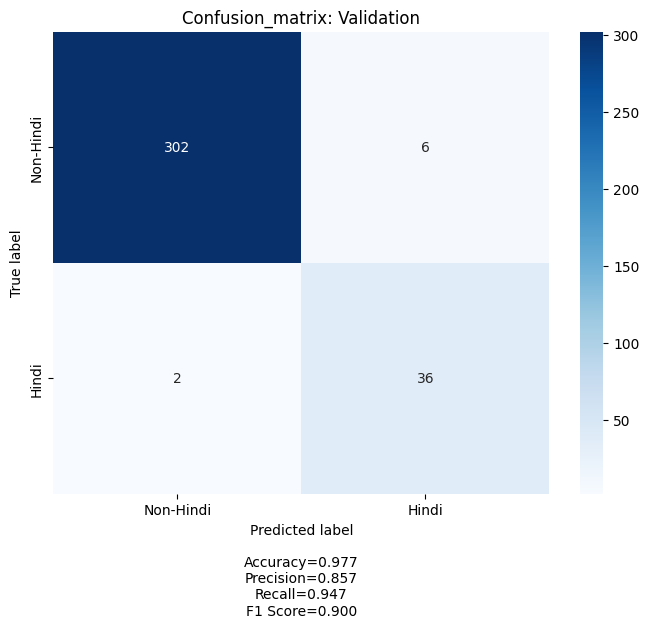

:::::Total validation loss 0.23206261346422252, Training accuracy 100.0%, Validation accuracy 97.6878612716763% after 46 epochs
Epoch: 47, Batch: 0, Loss: 0.0010182997211813927, Accuracy: 100.0%
Total training loss 0.003715667388557146 and training Accuracy 100.0% after 47 epochs
#####TEST--in-domain:::::Epoch: 47, Batch: 0, Loss: 0.0013795127160847187, Accuracy:100.0%


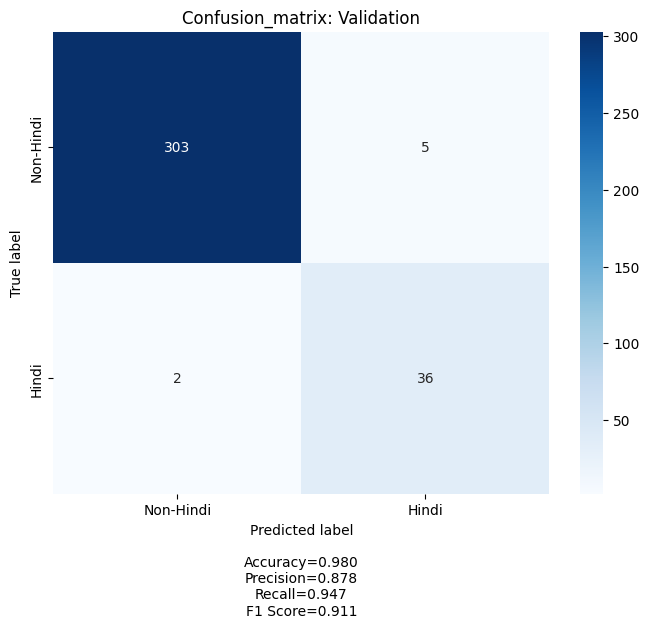

:::::Total validation loss 0.2133109619757055, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 47 epochs
Epoch: 48, Batch: 0, Loss: 0.0019351266091689467, Accuracy: 100.0%
Total training loss 0.001594232982218576 and training Accuracy 100.0% after 48 epochs
#####TEST--in-domain:::::Epoch: 48, Batch: 0, Loss: 3.7252898543727042e-09, Accuracy:100.0%


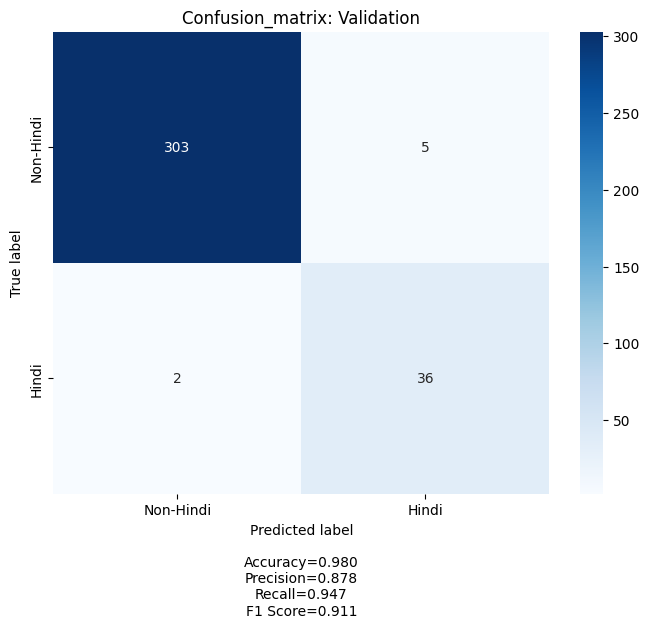

:::::Total validation loss 0.31885292102136487, Training accuracy 100.0%, Validation accuracy 97.97687861271676% after 48 epochs
Epoch: 49, Batch: 0, Loss: 0.005131701473146677, Accuracy: 100.0%
Total training loss 0.015055851079523563 and training Accuracy 100.0% after 49 epochs
#####TEST--in-domain:::::Epoch: 49, Batch: 0, Loss: 0.00012025522300973535, Accuracy:100.0%


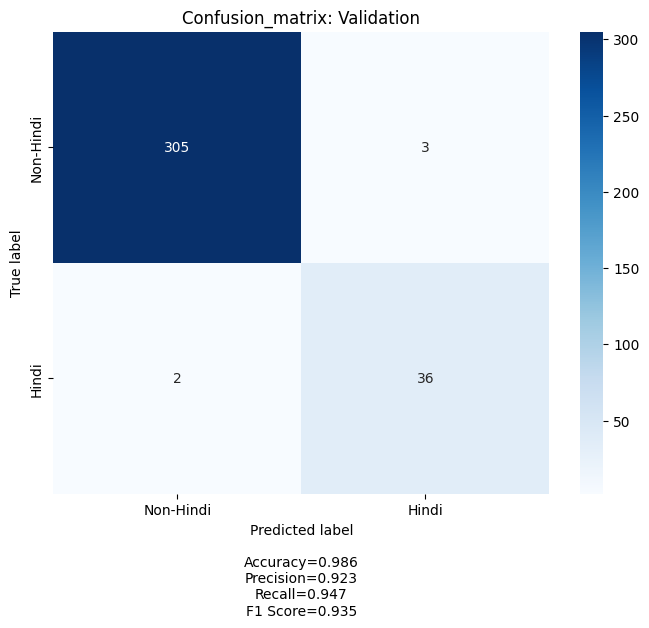

:::::Total validation loss 0.23473968227820782, Training accuracy 100.0%, Validation accuracy 98.55491329479769% after 49 epochs


: 

In [12]:
#For LR scheduler
import warnings
warnings.filterwarnings('ignore')
dest_path="/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/23lang_wav2_vec_features/hindi_binary_wav2vec_models/"
os.makedirs(dest_path,exist_ok=True)
Languages=["Assamese","Bengali","Bodo","Dogri","English","Gujarati","Hindi","Kannada","Kashmiri","Konkani","Maithili","Manipuri","Malayalam","Marathi","Nepali","Odia","Punjabi","Sanskrit","Santali","Sindhi","Tamil","Telugu","Urdu"]
#Languages=["Bengali","Hindi","Punjabi","Tamil","Urdu"]
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix

def train(dataloader_train, epoch):
    train_loss_list = []
    train_acc_list = []
    full_preds = []
    full_gts = []

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        features, labels = features.to(device).float(), labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss = model.get_loss(pred_logits, labels)
        posterior = model.get_posterior()

        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
        if i_batch % 50 == 0:
            acc = accuracy_score(predictions, labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy: {acc*100}%")
        train_loss_list.append(loss.item())
        full_preds.extend(predictions)
        full_gts.extend(labels.detach().cpu().numpy())

    mean_acc = accuracy_score(full_gts, full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    print(f'Total training loss {mean_loss} and training Accuracy {mean_acc*100}% after {epoch} epochs')
    return mean_acc

def validation(dataloader_val, epoch, train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        full_preds = []
        full_gts = []
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            features, labels = features.to(device).float(), labels.to(device).long()
            pred_logits = model(features)
            loss = model.get_loss(pred_logits, labels)
            posterior = model.get_posterior()
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
            if i_batch % 50 == 0:
                acc = accuracy_score(predictions, labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            full_preds.extend(predictions)
            full_gts.extend(labels.detach().cpu().numpy())

        mean_acc2 = accuracy_score(full_gts, full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm = confusion_matrix(full_gts, full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8, 6), categories=["Non-Hindi", "Hindi"], cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(f':::::Total validation loss {mean_loss2}, Training accuracy {train_accuracy*100}%, Validation accuracy {mean_acc2*100}% after {epoch} epochs')
        model_save_path = os.path.join(dest_path, f'original_VAD30_wav2vec2_xlsr_small_last16_cms_{train_accuracy*100:.3f}_{mean_acc2*100:.3f}_{mean_loss2:.4f}')
        state_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range(50):
        mean_acc = train(trainloader, epoch)
        val_loss = validation(testloader1, epoch, mean_acc)
        scheduler.step(val_loss)

# clear cuda memory

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()